<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version**



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [23]:
# ## install finrl library
!pip install wrds
!pip install swig
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install -e ~/Workspace/AI4Finance/FinRL

zsh:1: command not found: apt-get
Obtaining file:///Users/tonyren/Workspace/AI4Finance/FinRL
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /private/var/folders/fk/ghrbpzjd2ljb898y6fvw8sgc0000gn/T/pip-install-ad_340xc/elegantrl_b9f1b7daed7a4b678f5109d196a0cd29
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /private/var/folders/fk/ghrbpzjd2ljb898y6fvw8sgc0000gn/T/pip-install-ad_340xc/elegantrl_b9f1b7daed7a4b678f5109d196a0cd29
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit c2939fefe0e3ec55601ded49e39fdf9d7d781ea0
  Preparing metadata (setup.py) ... done
  Building editable for finrl (pyproject.toml) ... done
  Created wheel for finrl: filename=finrl-0.3.6-py3-none-any.whl 

In [24]:
!pip install -e ~/Workspace/AI4Finance/FinRL

Obtaining file:///Users/tonyren/Workspace/AI4Finance/FinRL
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /private/var/folders/fk/ghrbpzjd2ljb898y6fvw8sgc0000gn/T/pip-install-3ac1umcl/elegantrl_78dadc25bb2e4e1cb375443ae88a60fe
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /private/var/folders/fk/ghrbpzjd2ljb898y6fvw8sgc0000gn/T/pip-install-3ac1umcl/elegantrl_78dadc25bb2e4e1cb375443ae88a60fe
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit c2939fefe0e3ec55601ded49e39fdf9d7d781ea0
  Preparing metadata (setup.py) ... done
  Building editable for finrl (pyproject.toml) ... done
  Created wheel for finrl: filename=finrl-0.3.6-py3-none-any.whl size=9103 sha256=ebb9a360ce7d0d9eb

<a id='1.3'></a>
## 2.3. Import Packages

In [25]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import CUSTOM_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
import itertools

/Users/tonyren/Workspace/AI4Finance/FinRL/.venv/lib/python3.10/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


<a id='1.4'></a>
## 2.4. Create Folders

In [2]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [64]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import CUSTOM_TICKER
from finrl.meta.preprocessor.preprocessors import FeatureEngineer

TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2022-11-10'
TEST_START_DATE = '2022-11-11'
TEST_END_DATE = '2024-11-11'

INDICATORS = ['log-ret', 'rsi_30', 'dx_30', 'chop_6', 'chop_30']

In [65]:
CUSTOM_TICKER = [
    "INTC",
    "AAPL",
    "CSCO",
    "AMD",
    "GE",
    "LVS",
    "PARA",
    "TSLA",
    "CMCSA",
    "PRGO",
    "BEN",
    "VZ",
    "F",
    "GME",
    "AMC",
    "PCG"
]

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [68]:
if True:
    df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = CUSTOM_TICKER).fetch_data()

    fe = FeatureEngineer(use_technical_indicator=True,
                         tech_indicator_list = INDICATORS,
                         use_turbulence=True,
                         user_defined_feature = False)

    processed = fe.preprocess_data(df)
    processed = processed.copy()
    processed = processed.fillna(0)
    processed = processed.replace(np.inf,0)
    processed.to_csv("datasets/processed.csv", index=False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (58705, 8)


/Users/tonyren/Workspace/AI4Finance/FinRL/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/tonyren/Workspace/AI4Finance/FinRL/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/tonyren/Workspace/AI4Finance/FinRL/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/tonyren/Workspace/AI4Finance/FinRL/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/tonyren/Workspace/AI4Finance/FinRL/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1

Successfully added technical indicators
Successfully added turbulence index


In [69]:
processed

,date,open,high,low,close,volume,tic,day,log-ret,rsi_30,dx_30,chop_6,chop_30,turbulence
0,2010-01-04,6.44741,7.64321,7.66071,7.62250,493729600,AAPL,0,0.00000,100.00000,100.00000,0.00000,0.00000,0.00000
1,2010-01-04,9.70000,9.70000,9.90000,9.79000,18748700,AMD,0,0.00000,100.00000,100.00000,0.00000,0.00000,0.00000
2,2010-01-04,21.36558,36.00000,36.10667,35.39333,3746700,BEN,0,0.00000,100.00000,100.00000,0.00000,0.00000,0.00000
3,2010-01-04,6.25072,8.48500,8.56500,8.37500,27146800,CMCSA,0,0.00000,100.00000,100.00000,0.00000,0.00000,0.00000
4,2010-01-04,16.47537,24.69000,24.84000,24.11000,59853700,CSCO,0,0.00000,100.00000,100.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52341,2024-11-08,50.38000,50.38000,50.75000,50.55000,8699100,LVS,4,-0.01551,56.04919,3.75987,100.75427,73.11947,7.36425
52342,2024-11-08,11.07000,11.07000,11.54000,11.51000,15682600,PARA,4,0.01224,60.23499,59.22331,65.70096,44.84671,7.36425
52343,2024-11-08,20.60000,20.60000,20.71000,20.34000,15107800,PCG,4,0.00049,55.60734,15.52867,83.05106,64.30301,7.36425
52344,2024-11-08,26.36000,26.36000,26.91000,26.86000,1634300,PRGO,4,-0.02173,52.33378,8.96910,71.82215,57.53162,7.36425


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [70]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 14, State Space: 99


In [71]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1,
    "print_verbosity":1

}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [72]:
rebalance_window = 60 # rebalance_window is the number of days to retrain the model
validation_window = 300 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)


In [73]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.001
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.0001,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      "action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 100_000,
                      "learning_rate": 0.0001,
                      "batch_size": 256,
                      "gamma": 0.99
                    }

SAC_model_kwargs = {
    "batch_size": 64,
    "buffer_size": 100000,
    "learning_rate": 0.001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

TD3_model_kwargs = {"batch_size": 100, "buffer_size": 1_000_000, "learning_rate": 0.0001}

timesteps_dict = {'a2c' : 1,
                 'ppo' : 1,
                 'ddpg' : 10000,
                 'sac' : 1,
                 'td3' : 1
                 }

In [ ]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 SAC_model_kwargs,
                                                 TD3_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  104.036071100193
======Model training from:  2010-01-01 to  2022-11-14
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.001}
Using cpu device
Logging to tensorboard_log/a2c/a2c_360_5
======a2c Validation from:  2022-11-14 to  2024-01-26
day: 299, episode: 1
begin_total_asset: 1000000.00
end_total_asset: 1088217.20
total_reward: 88217.20
total_cost: 12591.11
total_trades: 3916
Sharpe: 1.567
a2c Sharpe Ratio:  0.19742104240107786
======ddpg Training========
{'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]), 'buffer_size': 100000, 'learning_rate': 0.0001, 'batch_size': 256, 'gamma': 0.99}
Using cpu device
Logging to tensorboard_log/ddpg/ddpg_360_1


In [62]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe,SAC Sharpe,TD3 Sharpe


In [ ]:
%tensorboard --logdir ./tensorboard_log/td3


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [124]:
np.__version__

'1.26.4'

In [125]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [126]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = pd.concat([df_account_value, temp], ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.28532945673161797


In [127]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2024-04-30,NaN,2024-04-30
1,9.999877e+05,2024-05-01,-0.000012,2024-05-01
2,9.999877e+05,2024-05-02,0.000000,2024-05-02
3,1.000119e+06,2024-05-03,0.000131,2024-05-03
4,1.000393e+06,2024-05-06,0.000274,2024-05-06


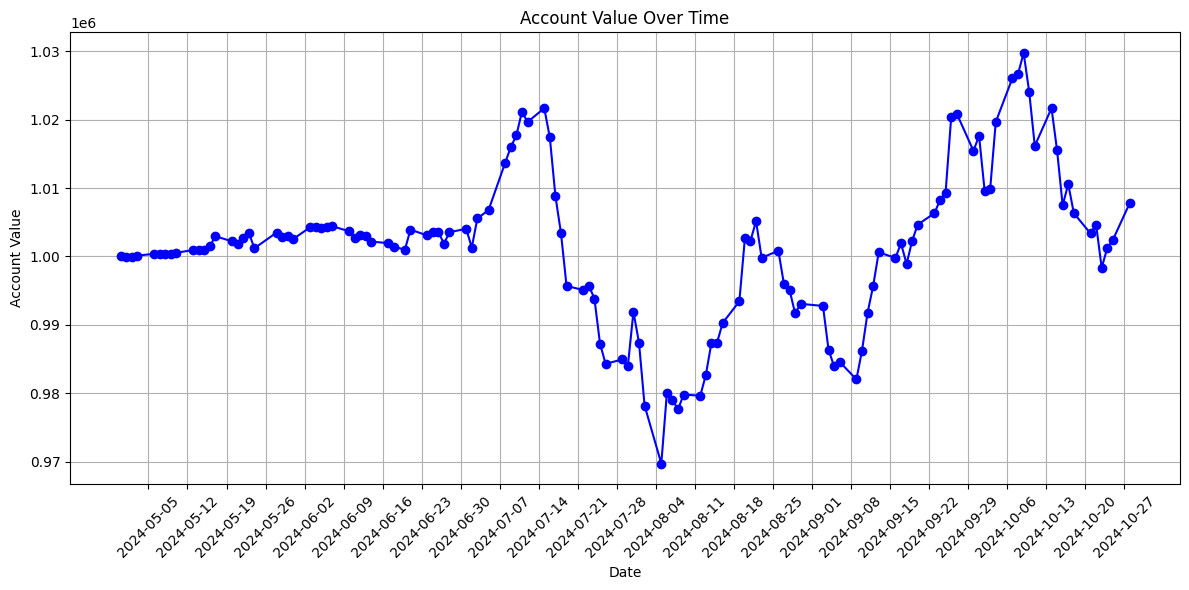

In [131]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
# Convert the date column to datetime format
#df_account_value['date'] = pd.to_datetime(df_account_value['date'])

# Set the date column as the index
#df_account_value.set_index('date', inplace=True)

# Visualization 1: Line plot for account value over time, with weekly xticks
plt.figure(figsize=(12, 6))
plt.plot(df_account_value.index, df_account_value['account_value'], marker='o', color='b')
plt.title('Account Value Over Time')
plt.xlabel('Date')
plt.ylabel('Account Value')

# Set xticks to display weekly intervals
plt.xticks(pd.date_range(start=df_account_value.index.min(), end=df_account_value.index.max(), freq='W'))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

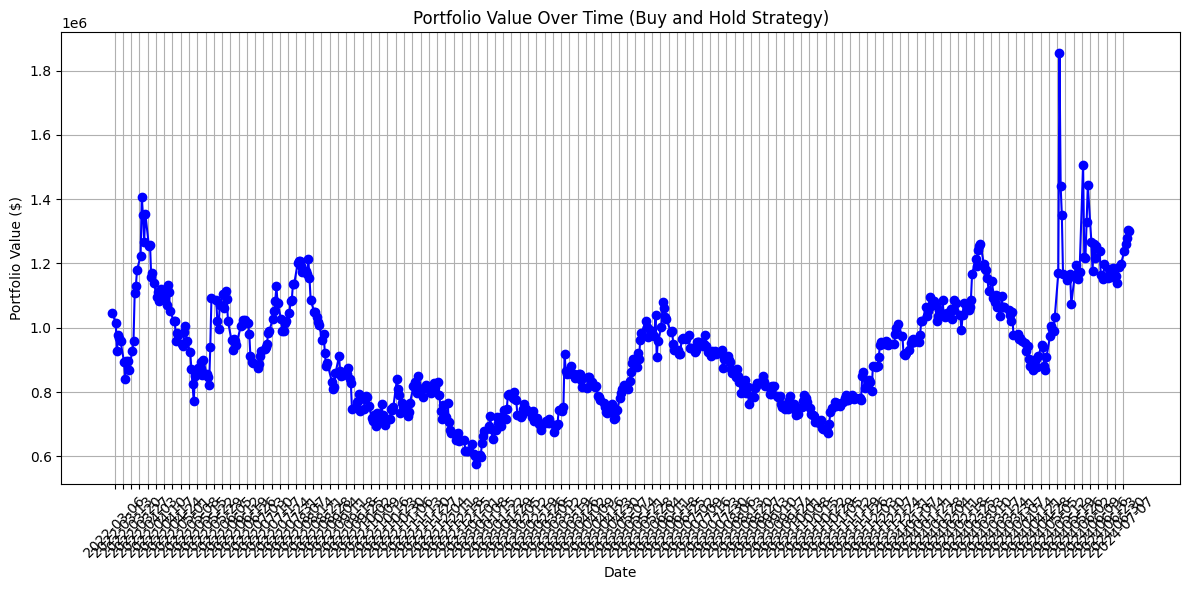

Annual return          0.097728
Cumulative returns     0.244889
Annual volatility      0.766403
Sharpe ratio           0.475590
Calmar ratio           0.165844
Stability              0.043754
Max drawdown          -0.589278
Omega ratio            1.100981
Sortino ratio          0.829575
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.048478
Daily value at risk   -0.095111
dtype: float64


In [132]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the processed dataframe
portfolio_data = processed.copy()

# Ensure the date column is in datetime format in the copied dataframe
portfolio_data['date'] = pd.to_datetime(portfolio_data['date'])

# Set the initial investment amount
initial_investment = 1_000_000

# Define the start and end dates for the analysis
start_date = pd.to_datetime('2022-03-04')
end_date = pd.to_datetime('2024-07-14')

# Filter the dataframe for the starting date to get initial prices
initial_prices = portfolio_data[portfolio_data['date'] == start_date].copy()

# Calculate the number of shares purchased for each stock
initial_prices['shares'] = initial_investment / len(initial_prices) / initial_prices['open']

# Merge the number of shares into the copied dataframe
portfolio_data = portfolio_data.merge(initial_prices[['tic', 'shares']], on='tic', how='inner')

# Calculate the daily portfolio value
portfolio_data['daily_value'] = portfolio_data['close'] * portfolio_data['shares']
df_account_value_buynhold = portfolio_data.groupby('date')['daily_value'].sum().reset_index()
df_account_value_buynhold.rename(columns={'daily_value': 'account_value'}, inplace=True)

# Filter the data between the start_date and end_date
df_account_value_buynhold['date'] = pd.to_datetime(df_account_value_buynhold['date'])
df_account_value_buynhold = df_account_value_buynhold[
    (df_account_value_buynhold['date'] >= start_date) & (df_account_value_buynhold['date'] <= end_date)
]

# Set the date column as the index
df_account_value_buynhold.set_index('date', inplace=True)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(df_account_value_buynhold.index, df_account_value_buynhold['account_value'], marker='o', color='b')
plt.title('Portfolio Value Over Time (Buy and Hold Strategy)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')

# Set xticks to display weekly intervals
plt.xticks(pd.date_range(start=df_account_value_buynhold.index.min(),
                         end=df_account_value_buynhold.index.max(), freq='W'))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
df_account_value_buynhold['datadate'] = list(df_account_value_buynhold.index)
df_account_value_buynhold['date'] = list(df_account_value_buynhold.index)
perf_stats_all = backtest_stats(account_value=df_account_value_buynhold)
perf_stats_all = pd.DataFrame(perf_stats_all)



<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [28]:
df_account_value = df_account_value.reset_index()

In [29]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.010978
Cumulative returns    -0.005504
Annual volatility      0.160644
Sharpe ratio           0.010510
Calmar ratio          -0.112026
Stability              0.012606
Max drawdown          -0.097997
Omega ratio            1.002037
Sortino ratio          0.014755
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.079211
Daily value at risk   -0.020233
dtype: float64


In [30]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

[*********************100%***********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (125, 8)
Annual return          0.057152
Cumulative returns     0.027952
Annual volatility      0.114338
Sharpe ratio           0.546898
Calmar ratio           0.971835
Stability              0.224720
Max drawdown          -0.058808
Omega ratio            1.096895
Sortino ratio          0.752622
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.912030
Daily value at risk   -0.014157
dtype: float64


In [ ]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')


<a id='6.2'></a>
## 7.2 BackTestPlot

In [31]:


# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value,
#               baseline_ticker = '^DJI',
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result.csv")
result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date:         datadate
0    2023-11-13
1    2023-11-14
2    2023-11-15
3    2023-11-16
4    2023-11-17
..          ...
245  2024-11-04
246  2024-11-05
247  2024-11-06
248  2024-11-07
249  2024-11-08

[250 rows x 1 columns]
df_result_ensemble:                  ensemble
date                    
2024-02-14  1.000000e+06
2024-02-15  1.000642e+06
2024-02-16  1.000719e+06
2024-02-20  9.978955e+05
2024-02-21  9.947947e+05
...                  ...
2024-08-08  9.915603e+05
2024-08-09  9.921889e+05
2024-08-12  9.929821e+05
2024-08-13  9.936269e+05
2024-08-14  9.944957e+05

[126 rows x 1 columns]
==============Compare to DJIA===========


NameError: name 'df_dji' is not defined